# Lab 7 - Finding the Rumor Source

###  Peter Kairouz and Pramod Viswanath

In this lab, you will learn how to design **message passing** algorithms to locate the source of a rumor in a given network. 

After filling this notebook and running all the cells, rename the file **lab7.ipynb** to **firstname_lastname_lab7.ipynb**, include your **well commented** code, and submit it by email. Avoid unneeded steps/computations and make sure your code runs before submitting it. Grading is based on your submission which is due at **4 p.m. March 9, 2016**. Your grade will be deducted 20 points for each day after the due date (late penalty).

**You will need the following functions from Lab 6.**

In [2]:
%matplotlib inline
from pylab import *
import random as rnd
import networkx as nx
from __future__ import division

rcParams['figure.figsize'] = 12, 12  # that's default image size for this interactive session

def draw_graph(graph, labels=None, graph_layout='shell',
               node_size=1600, node_color='blue', node_alpha=0.3,
               node_text_size=12,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):
    """ 
    Based on: https://www.udacity.com/wiki/creating-network-graphs-with-python
    We describe a graph as a list enumerating all edges.
    Ex: graph = [(1,2), (2,3)] represents a graph with 2 edges - (node1 - node2) and (node2 - node3)
    """
    
    # create networkx graph
    G=nx.Graph()

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)
    # show graph
    plt.show()
    
def build_adjacency(filename, min_degree, num_nodes):
    
    adjacency = [[] for i in range(num_nodes)]
    
    # open the datafile
    f = open(filename,'rb')
    
    edges = f.readlines()
    
    # add all the edges
    for edge in edges:
        edge = edge.split()
        source = int(edge[0]) - 1
        destination = int(edge[1]) - 1
        if (destination < num_nodes):
            adjacency[source].append(destination)
            adjacency[destination].append(source)
    
    # zero out the people with fewer than min_degree friends
    while True:
        loopflag = True
        for i in range(len(adjacency)):
            if len(adjacency[i]) < min_degree and len(adjacency[i]) > 0:
                loopflag = False
                for node in adjacency[i]:
                    adjacency[node].remove(i)
                adjacency[i] = []
        if loopflag:
            break
    
    return adjacency

def adjacency_to_graph(adjacency):
    graph = []
    for node in range(len(adjacency)):
        if adjacency[node]:
            for neighbors in range(len(adjacency[node])):
                graph.append((node, adjacency[node][neighbors]))             
    return graph

def generate_source(adjacency):
    num_nodes = len(adjacency)
    while True:
        source = rnd.randint(0,num_nodes-1)
        if len(adjacency[source]) > 0:
            break
    return source

def si_model_rumor_spreading(source, adjancency, N):
    infctn_pattern = [-1]*N;
    who_infected = [[] for i in range(N)]
    
    # adding the source node to the list of infected nodes
    infctn_pattern[0] = source
    susceptible_nodes = adjacency[source]
    susceptible_indices = [0]*len(susceptible_nodes)
        
    for i in range(1,N):
        
        # infect the first node
        infctd_node_idx = rnd.randrange(0,len(susceptible_nodes),1)
        infctn_pattern[i] = susceptible_nodes[infctd_node_idx]
        who_infected[i] = [susceptible_indices[infctd_node_idx]]
        who_infected[susceptible_indices[infctd_node_idx]].append(i)
        
        # updating susceptible_nodes and susceptible_indices
        susceptible_indices = [susceptible_indices[j] for j in range(len(susceptible_nodes)) if susceptible_nodes[j] 
                               != susceptible_nodes[infctd_node_idx]]
        susceptible_nodes = [susceptible_nodes[j] for j in range(len(susceptible_nodes)) if susceptible_nodes[j] 
                             != susceptible_nodes[infctd_node_idx]]
        infctd_nodes = set(infctn_pattern[:i+1]) 
        new_susceptible_nodes = set(adjacency[infctn_pattern[i]])                     
        new_susceptible_nodes = list(new_susceptible_nodes.difference(infctd_nodes))
        susceptible_nodes  = susceptible_nodes  + new_susceptible_nodes 
        susceptible_indices = susceptible_indices + [i]*len(new_susceptible_nodes)

    return who_infected, infctn_pattern
    

----

## Problem 0: Graph Traversal (0 pts)

Assume that you are given the adjacency list of a tree. Choose any node in the adjacency list to be the root of the tree. Write down a function called `upward_pass` that accepts the adjacency list and root node as arguments and does the following. It uses a recursive depth first search (DFS) traversal algorithm to pass messages from the leaf nodes up to the root node. The leaf nodes should pass 1 to their parent nodes. Intermediate nodes should sum the incoming messages, increment the sum by 1, and then pass the final result to their parent node. The algorithm stops whenever you hit the chosen root node. The function should return the list of values that were passed by each node in the tree.

[7, 3, 3, 1, 1, 1, 1]


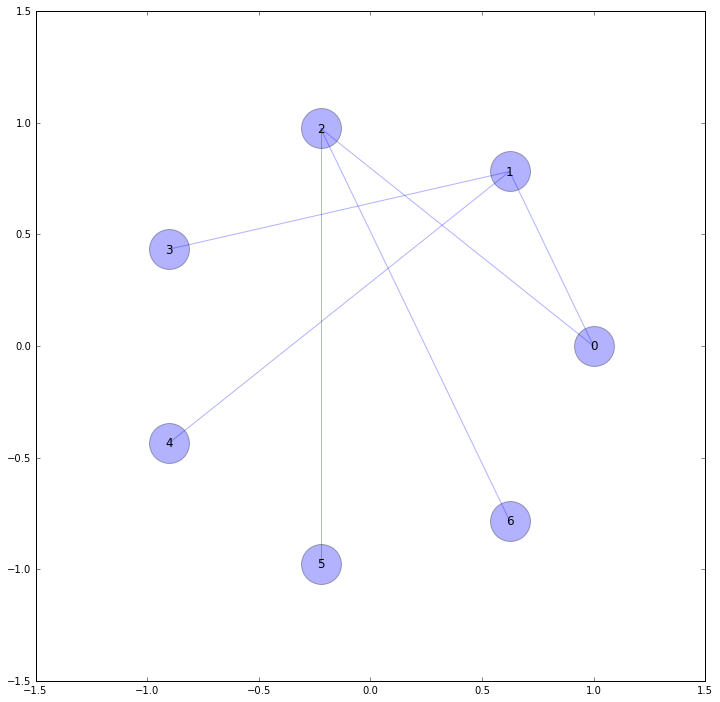

In [3]:
def message_passing_up(up_messages, who_infected, calling_node, called_node):
    if called_node == calling_node:  # root node
        for i in who_infected[called_node]:
                up_messages = message_passing_up(up_messages, who_infected, called_node, i)
    elif len(who_infected[called_node]) == 1:   # leaf node
        up_messages[calling_node] += 1 
    else:
        for i in who_infected[called_node]: #
            if i != calling_node:
                up_messages = message_passing_up(up_messages, who_infected, called_node, i)
        up_messages[calling_node] += up_messages[called_node]
    return up_messages  

# creating a toy graph (tree)
adjacency = [ [] for i in range(7)]
adjacency[0] = [1, 2]
adjacency[1] = [0, 3, 4]
adjacency[2] = [0, 5, 6]
adjacency[3] = [1]
adjacency[4] = [1]
adjacency[5] = [2]
adjacency[6] = [2]

root_node = 0 # can use any arbitrary index for the root node
up_messages = [1]*len(adjacency) 
messages = message_passing_up(up_messages, adjacency, root_node, root_node)
print messages
graph = adjacency_to_graph(adjacency)
draw_graph(graph)

----

## Problem 1: Rumor Centrality (35 pts)

Use the code provided in problem 0 to complete the functions below.

- rumor_centrality_up should mimick message_passing_up (the function provided in Problem 0). Instead of passing/calculating 1 message (the t message), you are to modify that code to pass/calculate 2 messages (the t and p messages). 
- rumor_centrality_down should accept the up_messages that were returned by rumor_centrality_up as input, and use a BFS recursive algorithm to pass down the r messages.
- rumor_centrality should first call rumor_centrality_up and then rumor_centrality_down. You can choose node 0 (the true source) to be the root node passed to both functions. After running rumor_centrality_up, feed the up_messages (returned by rumor_centrality_up) as an input to rumor_centrarlity_down. In rumor_centrality_down, remove the N!/N term when computing the rumor centrality of the root node. After calling both functions, down_messages (returned by rumor_centrality_down) will contain the rumor centralities of all N infected nodes. Find the index of the node that has the largest rumor centrality and return it as the the "rumor source". If more than one node has the highest rumor centrality, break the ties uniformly at random.

[8, 3, 4, 1, 1, 1, 2, 1]
[192, 3, 8, 1, 1, 1, 2, 1]
[0.041666666666666664, 0.024999999999999998, 0.041666666666666664, 0.005952380952380952, 0.005952380952380952, 0.005952380952380952, 0.013888888888888888, 0.005952380952380952]
2


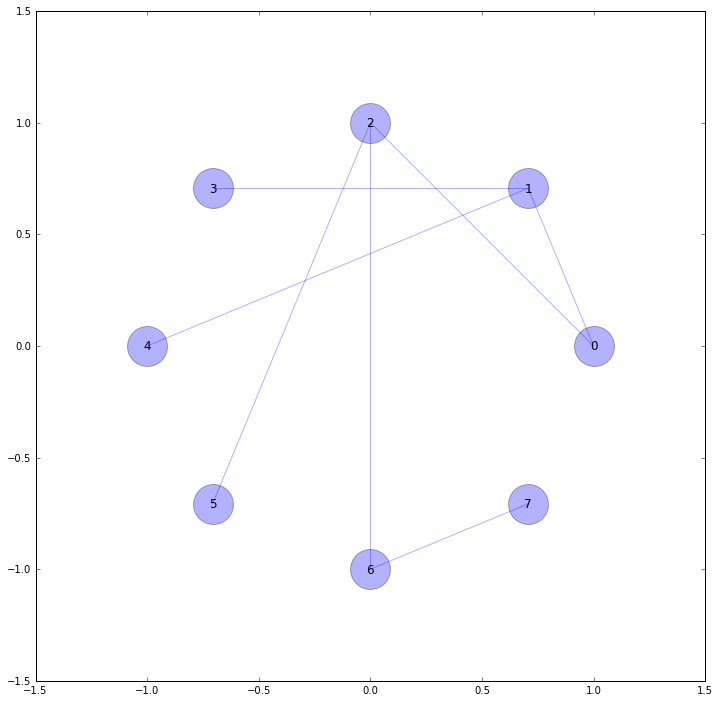

In [4]:
import random
def rumor_centrality_up(up_messages_t,up_messages_p, who_infected, calling_node, called_node):
    if called_node == [] or calling_node == [] or up_messages_t[calling_node]==[] or who_infected[calling_node] == []  or who_infected[called_node] ==[]: #or up_messages_t[calling_node]==[] or up_messages_p[calling_node]==[] :
        return up_messages_t,up_messages_p
    if called_node == calling_node:  # root node
        for i in who_infected[called_node]:
                up_messages_t,up_messages_p = rumor_centrality_up(up_messages_t,up_messages_p, who_infected, called_node, i)                
    elif len(who_infected[called_node]) == 1:   # leaf node
        up_messages_t[calling_node] += 1        # inr up message
        up_messages_p[calling_node] = up_messages_t[calling_node] * up_messages_p[called_node]  # multiply by all it's neighbors
        
    else:
        for i in who_infected[called_node]: 
            if i != calling_node: 
                up_messages_t,up_messages_p = rumor_centrality_up(up_messages_t,up_messages_p, who_infected, called_node, i)    
        up_messages_t[calling_node] += up_messages_t[called_node] #calcaulate the t message first
        product = 1  #local scope variable 
        for x in who_infected[calling_node]: # Get the product of all the neighbors of calling node
            product =  product * up_messages_p[x] #Parents have an up message of 1 so we aren't worried
        up_messages_p[calling_node]  = up_messages_t[calling_node] * product #multiply by it's t message.  
    return up_messages_t,up_messages_p  
          

def rumor_centrality_down(down_messages, up_messages_t,up_messeges_p, who_infected, calling_node, called_node):
    n = len(who_infected)
    if called_node == [] or calling_node == [] or up_messages_t[calling_node]==[] or who_infected[calling_node] == []  or who_infected[called_node] ==[]: #or up_messages_t[calling_node]==[] or up_messages_p[calling_node]==[] :
        return down_messages
    if called_node == calling_node:  # root node
        product = 1
        for x in who_infected[calling_node]: # Get the product of all the neighbors of calling node
            if x == [] :
                continue
            product =  product * up_messages_p[x] #Parents have an up message of 1 so we aren't worried
        down_messages[calling_node] = 1.0/product
        for i in who_infected[calling_node]:
            down_messages = rumor_centrality_down(down_messages, up_messages_t,up_messages_p, who_infected, calling_node,i)
                
    else:
        down_messages[called_node] = down_messages[calling_node] * (float(up_messages_t[called_node]) /(n-up_messages_t[called_node]))
        for i in who_infected[called_node]:
            if down_messages[i] == -1.0: #Only need to change down messages for children
                down_messages = rumor_centrality_down(down_messages, up_messages_t,up_messages_p, who_infected, calling_node, i)
    return down_messages 


def rumor_centrality(who_infected):
    root_node = 0 # can use any arbitrary index for the root node
    up_messages_t = [1]*len(who_infected) 
    up_messages_p = [1]*len(who_infected)
    down_messages = [-1.0]*len(who_infected)
    messages_t,messages_p = rumor_centrality_up(up_messages_t,up_messages_p, who_infected, root_node, root_node)
    down_messages = rumor_centrality_down(down_messages, messages_t, messages_p, who_infected, root_node, root_node)
    m = max(down_messages)
    highest = [i for i, j in enumerate(down_messages) if j == m]
    return random.choice(highest)

# creating a toy graph (tree) , same as above with slight modification
adjacency = [ [] for i in range(8)]
adjacency[0] = [1, 2]
adjacency[1] = [3, 4]
adjacency[2] = [5, 6]
adjacency[3] = [1]
adjacency[4] = [1]
adjacency[5] = [2]
adjacency[6] = [2 , 7]
adjacency[7] = [6]
root_node = 0 # can use any arbitrary index for the root node
up_messages_t = [1]*len(adjacency) 
up_messages_p = [1]*len(adjacency)

messages_t,messages_p = rumor_centrality_up(up_messages_t,up_messages_p, adjacency, root_node, root_node)
print messages_t
print messages_p

down_messages = [-1.0]*len(adjacency)
down_messages = rumor_centrality_down(down_messages, messages_t, messages_p, adjacency, root_node, root_node)

print down_messages

print rumor_centrality(adjacency)

graph = adjacency_to_graph(adjacency)
draw_graph(graph)


----

## Problem 2: Jordan Centrality (35 pts)

Use the code provided in problem 0 to complete the functions below.

- jordan_centrality_up should mimick message_passing_up (the function provided in Problem 0). Instead of passing/calculating 1 message (the t messages), you are to modify that code to pass/calculate 2 messages (the l1 and l2 messages). 
- jordan_centrality_down should accept the up_messages that were returned by jordan_centrality_up as input, and use a BFS recursive algorithm to pass down the messages and check the condition l1 - l2 <= 1. As soon as the condition is met, the search is halted and the index of that node is returned as the jordan center. 
- jordan_centrality should first call jordan_centrality_up and then jordan_centrality_down. Make sure to choose the inital root node that you're going to pass to jordan_centrality_up and jordan_centrality_down uniformly at random. After calling jordan_centrality_up, feed the up_messages (returned by jordan_centrality_up) as an input to jordan_centrarlity_down. Simply return the output of jordan_centrality_down as the jordan_center of the infected graph.

[1, 2, 1, 2, 1]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]


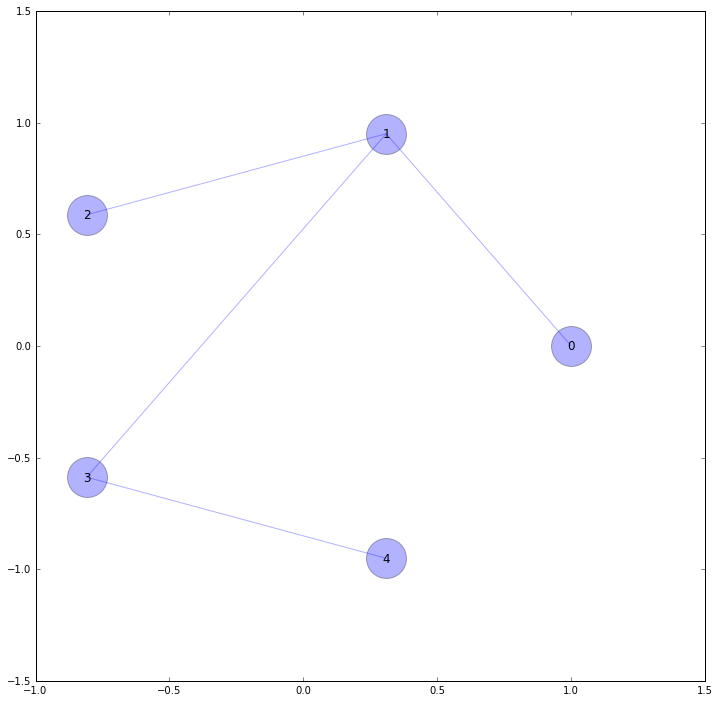

In [5]:
import numpy as np

def jordan_centrality_up(up_messages,l1,l2 ,who_infected, calling_node, called_node):
    if called_node == calling_node:  # root node
        for i in who_infected[called_node]:
                up_messages,l1,l2 = jordan_centrality_up(up_messages,l1,l2, who_infected, called_node, i)
    elif len(who_infected[called_node]) == 1:   # leaf node
        up_messages[calling_node] += 1 
        l1[calling_node] = 0
        l2[calling_node] = 0
    else:
        for i in who_infected[called_node]: #
            if i != calling_node:
                up_messages,l1,l2 = jordan_centrality_up(up_messages,l1,l2, who_infected, called_node, i)
        temp = up_messages[called_node]
    
            
    return up_messages,l1,l2

def jordan_centrality_down(down_messages, up_messages, who_infected, calling_node, called_node):
    # your code goes here
    
    return jordan_center

def jordan_centrality(who_infected):
    #your code goes here
    
    return jordan_center

# test the above functions on a non-trivial toy graph

adjacency = [ [] for i in range(5)]
adjacency[0] = [1]
adjacency[1] = [2, 3]
adjacency[2] = [1]
adjacency[3] = [1,4]
adjacency[4] = [3]
root = 0 # can use any arbitrary index for the root node
up_messages = [1]*len(adjacency) 
l1 = [0]*len(adjacency)
l2 = [0]*len(adjacency)
up_messages,l1,l2 = jordan_centrality_up(up_messages,l1,l2 ,adjacency, root, root)
print up_messages
print l1
print l2


graph = adjacency_to_graph(adjacency)
draw_graph(graph)


----

## Problem 3: Putting it All Together (30 pts)

Use the function `buildDatasetGraph` with `filename = out.facebook-wosn-links`, `num_nodes = 4941`, and `min_degree = 3` to load Facebook's social network.  After loading the social network, use the SI spreading model developed in Lab 6 to generate an infected subgraph of size $N$ (a parameter that will be specified in a bit). Estimate the source of the rumor using both rumor centrality (Problem 2) and Jordan centrality (Problem 3). For each case, the estimated rumor source $\hat{v}$ can be compared to the true rumor source $v^*$ to determine whether the detection was correct or wrong. This process can be repeated 1000 times in order to compute the **average probability of detection** $P_d(N)$ by counting the number of times we have $\hat{v}= v^*$ and dividing this number by 1000.


Consider $N=10:10:500$ and then for
each $N$ compute $P_d(N)$ (as described above) for both rumor centrality and Jordan centrality. The notation $N = 10 : 10 : 500$ is borrowed from MATLAB. It means $N = 10, 20, 30, 40, ...., 500$. So, $N$ goes from 10 to 500 in increments of 10. Plot $P_d(N)$ as a
function of $N$ (all on the same
figure) on a log-log scale.

**The above simulations will take a while (at least one hour) so make
sure you run them well before the deadline.**

In [7]:
N_min = 10 # min number of nodes to infect
N_max = 500 # max number of nodes to infect
Inc = 10 # increment
L = 1000 # number of trials

N_min = 1 # min number of nodes to infect
N_max = 12 # max number of nodes to infect
Inc = 1 # increment
L = 1 # number of trials

Pd_rumor = [] # initializing the detection probability list under rumor centrality to an empty list
Pd_jordan = [] # initializing the detection probability list under rumor centrality to an empty list
N_axis = []

# tweak this line to match the problem statement!
adjacency = build_adjacency('out.facebook-wosn-links',3,4941)
num_nodes = len(adjacency) # number of nodes in the underlying graph (this includes nodes with no neighbours)

for N in range(N_min, N_max + 1, Inc):
    N_axis.append(N)
    det_count = 0 # initializing the detection counter to zero

    for j in range(L):
        
        jordan_errors = 0 # this will keep track of the number of errors under rumor centrality
        
        rumor_errors = 0 # this will keep track of the number of errors under Jordan centrality
#         # select a rumor source at random  
#         source = generate_source(adjacency) 
#         # spread the rumor to N people and return who_infected (the adjacency list of the infection tree)
#         who_infected = si_model_rumor_spreading(source, adjacency, N)
#         # use rumor centrality to estimate the source
#         est_source = rumor_centrality(who_infected)
#         # figure out if rumor center = rumor soruce and update rumor_errors correspondingly
#         if (est_source != source):
#             rumor_errors += 1
            
        # user Jordan centrality to estimate the source
        
        # figure out if Jordan center = rumor soruce and update jordan_errors correspondingly
         
    Pd_rumor.append(float(rumor_errors)/L)
    Pd_jordan.append(float(jordan_errors)/L)

# tweak this code to (a) be a log-log plot and (b) include the jordan centrality probability of error
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
ax = plt.subplot(111)
plt.plot(N_axis, [y * 100 for y in Pd_rumor], lw = 2.0, label = "Probability of Detection")
plt.axis([N_min, N_max, 0, 150])
plt.xlabel("Number of Infected Nodes")
plt.ylabel("Probability of Detection (%)")
plt.legend(loc = "upper left")
plt.title("Rumor Centrality")
plt.grid(which = "minor")
plt.grid(which = "major")
ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

ValueError: Data has no positive values, and therefore can not be log-scaled.

**Questions**

- How does $P_d(N)$ vary as a function of $N$ under Jordan and rumor centrality? Why? 
- Is Jordan centrality better than rumor centrality? Why? 